<a href="https://colab.research.google.com/github/mobinnbagheriann/Generative-Models/blob/main/Generative_Models_(2)_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset

We are going to work on the FashionMNIST dataset. FashionMNIST consists of a training set of 60,000 examples and a test set of 10,000 samples. Each sample is a 28x28 grayscale image associated with a label from 10 classes. We are going to use the training split in this notebook. You can use `dataloader` to train your models. Also, you can use `plot_samples` to plot a sequence of images (e.g. iteratively denoised images by DDPM).

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
from tqdm.notebook import tqdm
from torch.autograd import Variable

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

BATCH_SIZE = 128
IMG_SIZE = 28
C_IN = 1 # Number of input channels
LR = 1e-4
EPOCHS = 20



DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

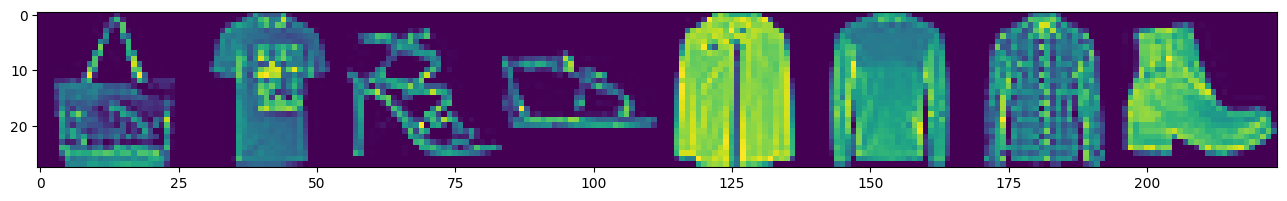

In [ ]:
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]

    data_transform = transforms.Compose(data_transforms)

    data = torchvision.datasets.FashionMNIST(root=".", download=True,
                                         train=True, transform=data_transform)
    return data


def plot_images(images):
    plt.figure(figsize=(16, 3))
    plt.imshow(torch.cat([
        torch.cat([i for i in images], dim=-1)
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE,
                        shuffle=True, drop_last=True)
batch_x, batch_y = next(iter(dataloader))
plot_images(batch_x[:8])

## VAE

VAE is a generative model consisting of an encoder network and a decoder network. The encoder maps the input data into a latent space, where the data is represented by probability distributions. A decoder network generates the output data from samples of the latent space.

VAE is trained using a variational inference approach, where the goal is to maximize the evidence lower bound (ELBO) of the log-likelihood of the data. The ELBO consists of two terms: the reconstruction loss, which measures how well the decoder can reconstruct the input data from the latent space, and the KL divergence between the prior (considered Gaussian) and posterior distributions over the latent space. The posterior distribution is usually considered Gaussian, and the encoder only tries to learn its mean and variance. Given the mean and the variance, one can use the reparameterization trick to sample from the encoder.

### ❓ **Question 1**

+ What is the reparameterization trick? How does it affect the sampling and the gradient backpropagation processes?
The reparameterization trick transforms a stochastic sampling operation into a differentiable deterministic transformation, ensuring that gradient-based learning can propagate smoothly through randomness, crucial for training generative models effectively.
+ What are the advantages of VAEs over regular Autoencoders?
Variational Autoencoders (VAEs) are better than regular autoencoders because they have a structured and probabilistic latent space, enabling them to generate new realistic data, handle uncertainty more effectively, generalize better through built-in regularization (via KL-divergence), and often produce more interpretable representations.


In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super(VariationalEncoder, self).__init__()
        input_size = IMG_SIZE * IMG_SIZE * C_IN
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mean = nn.Linear(256, kwargs.get('latent_dims', 20))
        self.fc_logvar = nn.Linear(256, kwargs.get('latent_dims', 20))
        self.activation = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        mean = self.fc_mean(x)
        log_var = self.fc_logvar(x)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z, mean, log_var
class Decoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Decoder, self).__init__()
        latent_dims = kwargs.get('latent_dims', 20)
        self.fc1 = nn.Linear(latent_dims, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, IMG_SIZE * IMG_SIZE * C_IN)
        self.activation = nn.ReLU()
        self.output_activation = nn.Tanh()

    def forward(self, z):
        z = self.activation(self.fc1(z))
        z = self.activation(self.fc2(z))
        z = self.fc3(z)
        z = self.output_activation(z)
        z = z.view(-1, C_IN, IMG_SIZE, IMG_SIZE)
        return z
class VariationalAutoEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super(VariationalAutoEncoder, self).__init__()
        self.latent_dims = kwargs.get('latent_dims', 20)
        self.encoder = VariationalEncoder(latent_dims=self.latent_dims)
        self.decoder = Decoder(latent_dims=self.latent_dims)

    def forward(self, x):
        z, mean, log_var = self.encoder(x)
        return self.decoder(z), mean, log_var
class VAEManager():
    def __init__(self, latent_dims=20):
        self.vae = VariationalAutoEncoder(latent_dims=latent_dims).to(DEVICE)
        self.optimizer = optim.Adam(self.vae.parameters(), lr=LR)

    def train(self, dataloader, **kwargs):
        history = {'loss': []}
        for epoch in range(EPOCHS):
            total_loss = []
            for batch_x, _ in tqdm(dataloader):
                batch_x = batch_x.to(DEVICE)
                self.optimizer.zero_grad()
                recon_x, mean, log_var = self.vae(batch_x)
                recon_loss = F.mse_loss(recon_x, batch_x, reduction='sum')
                kl_div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
                loss = (recon_loss + kl_div) / batch_x.size(0)
                loss.backward()
                self.optimizer.step()
                total_loss.append(loss.item())
            mean_loss = np.mean(total_loss)
            history['loss'].append(mean_loss)
            print(f"[Epoch {epoch+1}/{EPOCHS}] Loss: {mean_loss:.4f}")
            self.sample(8)
        return history

    def sample(self, n, plot=True):
        latent_dims = self.vae.latent_dims
        z1 = torch.randn(1, latent_dims, device=DEVICE)
        z2 = torch.randn(1, latent_dims, device=DEVICE)
        ratios = torch.linspace(0, 1, n, device=DEVICE).view(-1, 1)
        zs = z1 * (1 - ratios) + z2 * ratios
        with torch.no_grad():
            images = self.vae.decoder(zs)
            if plot:
                plot_images(images)
            return images

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 1/20] Loss: 170.9879


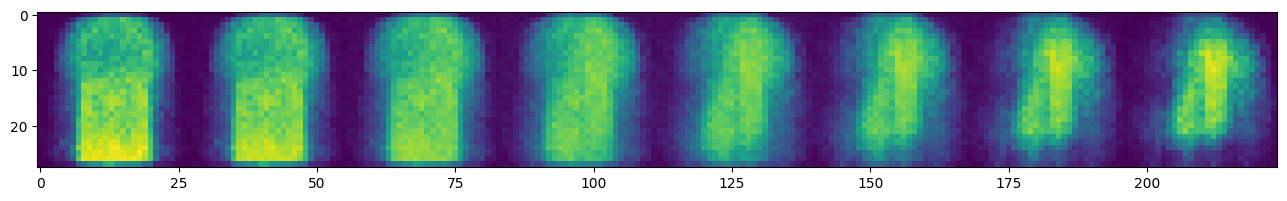

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 2/20] Loss: 98.6642


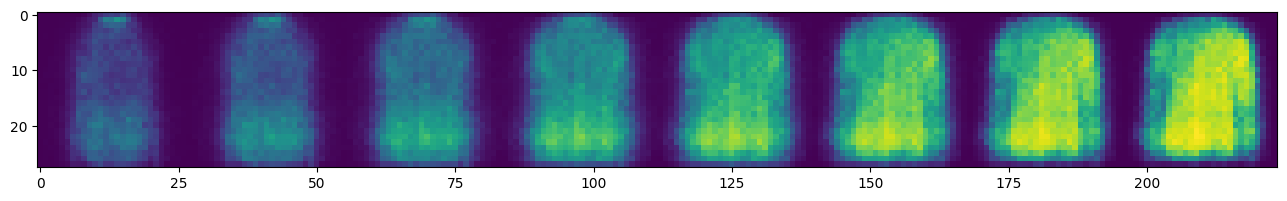

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 3/20] Loss: 90.2307


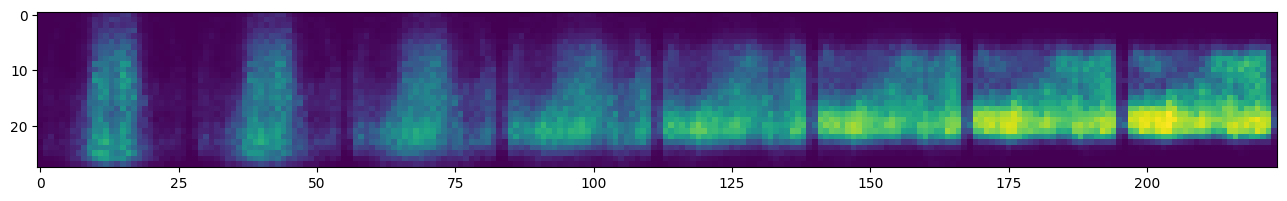

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 4/20] Loss: 85.0954


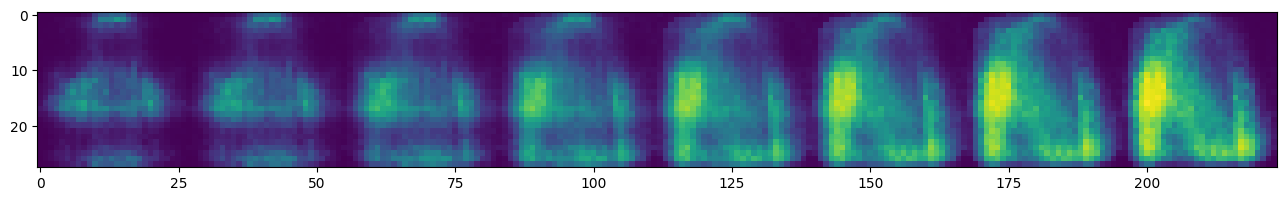

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 5/20] Loss: 81.4279


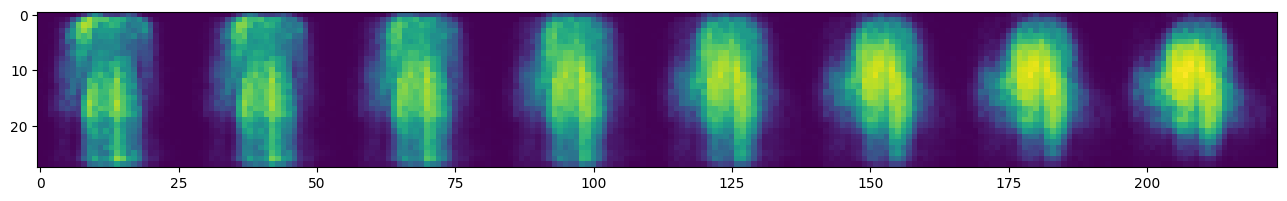

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 6/20] Loss: 78.9070


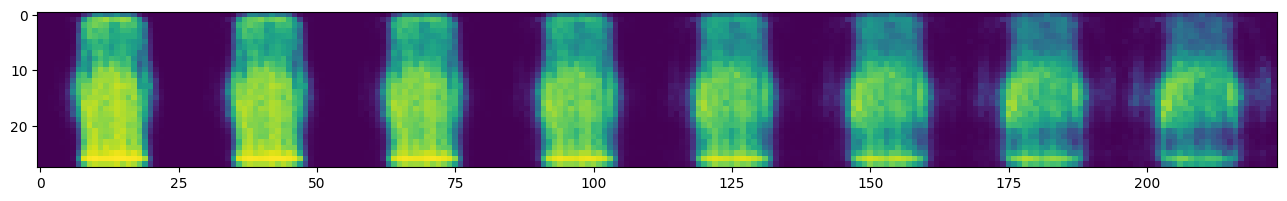

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 7/20] Loss: 77.0084


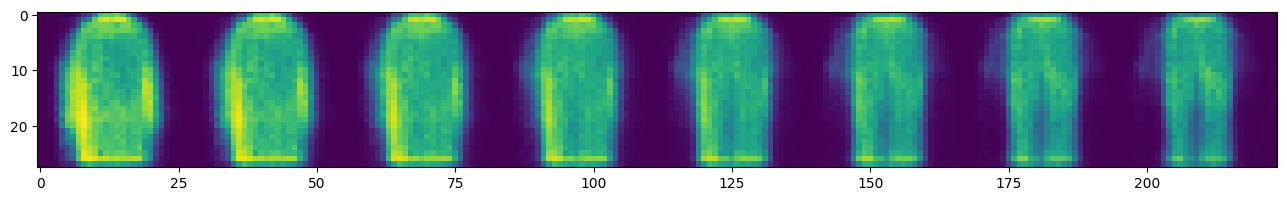

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 8/20] Loss: 75.5259


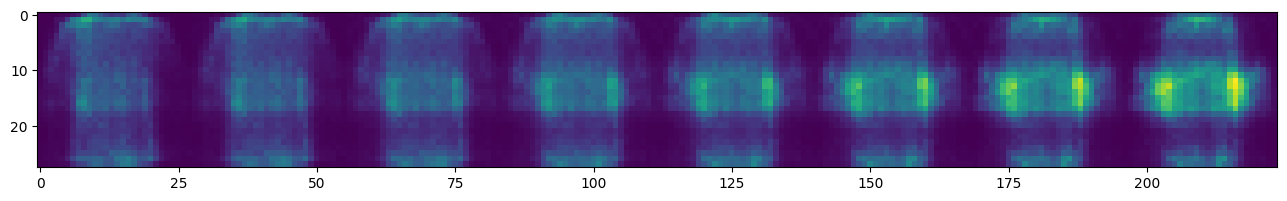

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 9/20] Loss: 74.2638


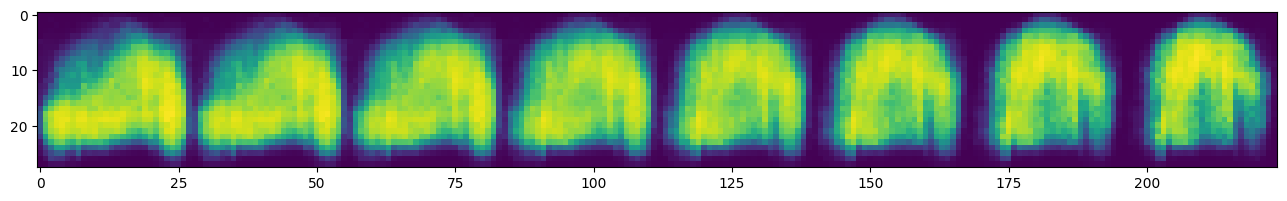

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 10/20] Loss: 73.1970


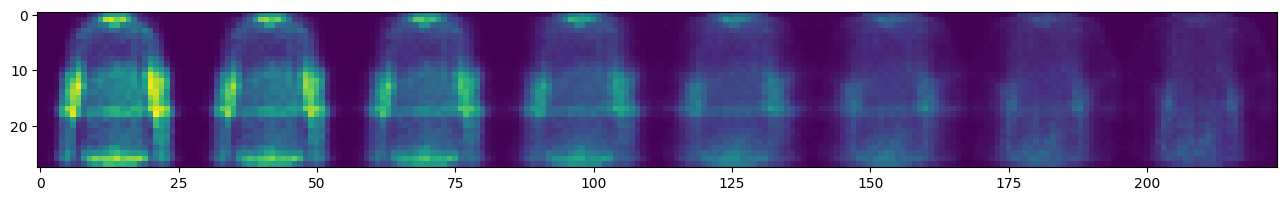

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 11/20] Loss: 72.2504


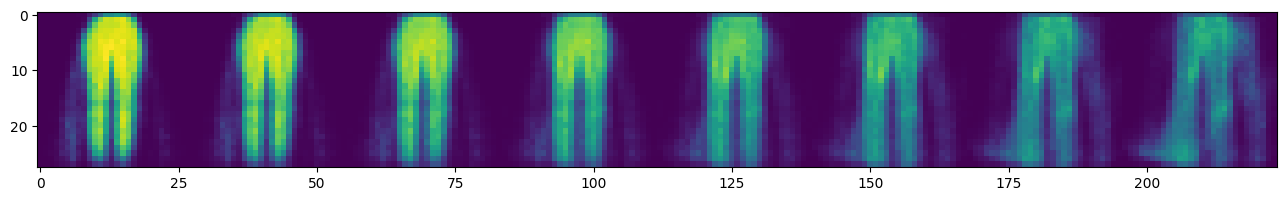

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 12/20] Loss: 71.4302


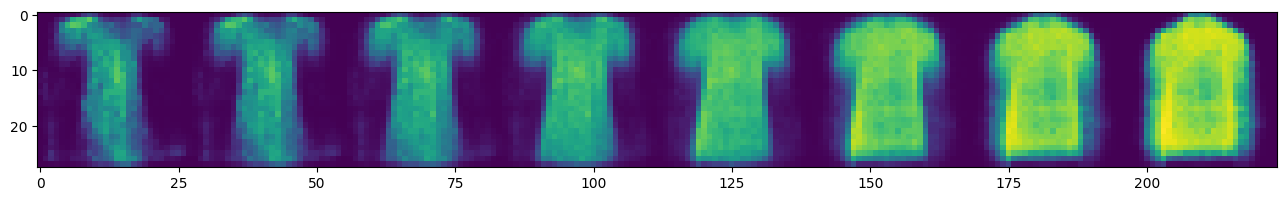

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 13/20] Loss: 70.7150


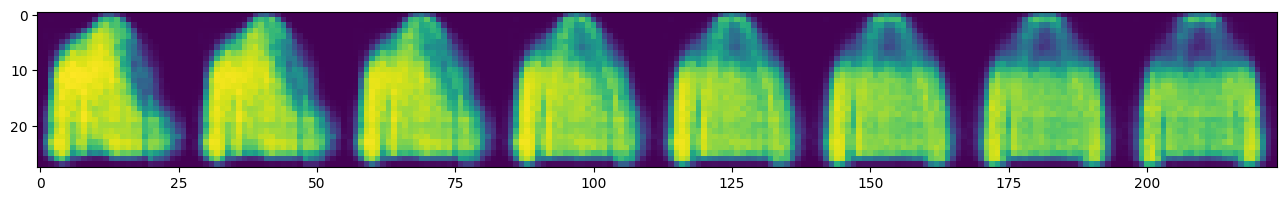

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 14/20] Loss: 70.1098


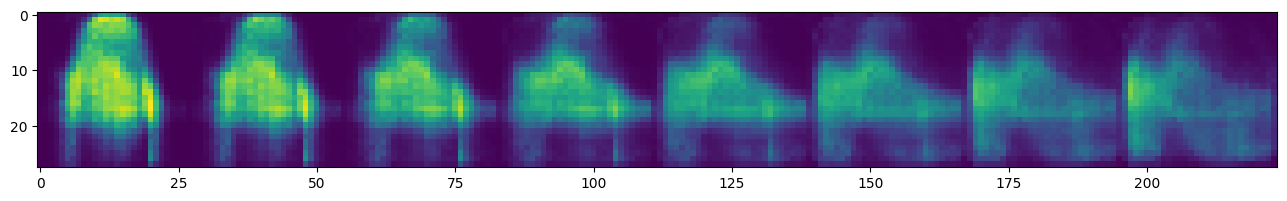

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 15/20] Loss: 69.5239


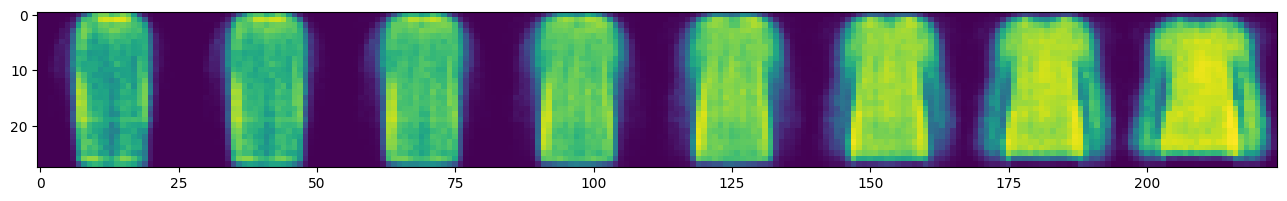

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 16/20] Loss: 69.0263


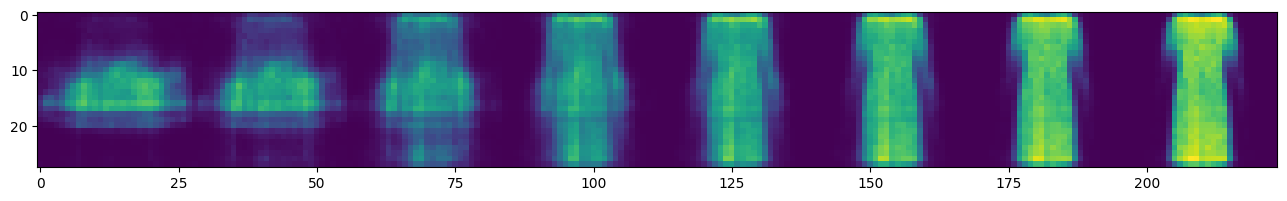

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 17/20] Loss: 68.5319


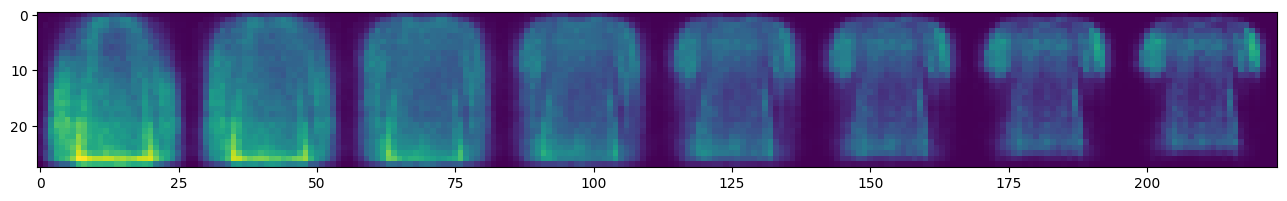

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 18/20] Loss: 68.1641


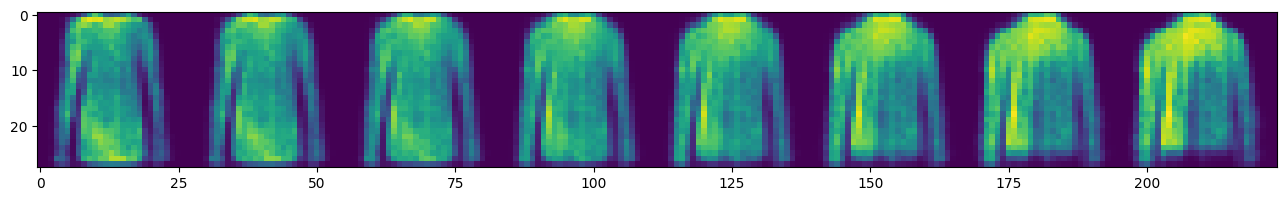

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 19/20] Loss: 67.7523


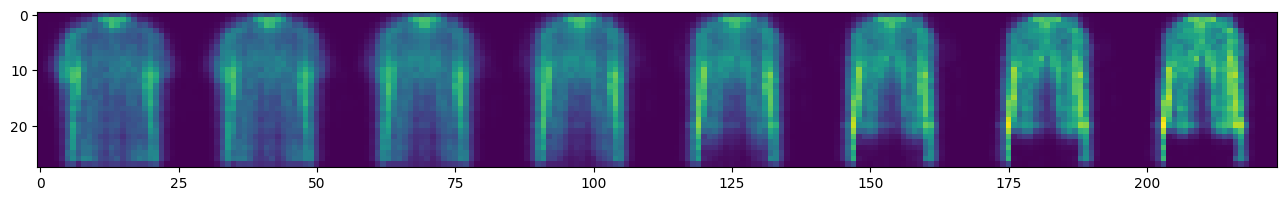

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 20/20] Loss: 67.3794


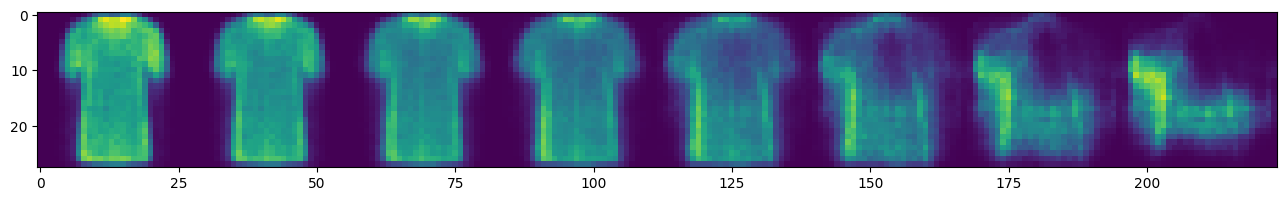

In [ ]:
vae = VAEManager(15) # You can pass your arguments to the call.
vae_history = vae.train(dataloader)

## GAN

GAN's architecture consists of a Discriminator and a Generator. The Discriminator identifies whether an input image ($x$) is real or generated by the Generator. The Generator tries to create fake images given a random noise ($z$) such that the Discriminator can not distinguish them from the real images. These functionalities give rise to an adversarial situation where these networks can be seen as players. Thus, the standard loss for GAN is the following min-max loss. The Generator tries to minimize it, while the Discriminator tries to maximize it.

$$ \min_{\theta_g} \max_{\theta_d} E_{x \sim p_{data}}[log(D_{\theta_d}(x)] + E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$

We try to optimize this loss function by alternating between the following objectives for the Discriminator and the Generator:
+ Discriminator's objective:
 $$ \max_{\theta_d} E_{x \sim p_{data}}[log(D_{\theta_d}(x)] + E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$
+ Generator's objective:
$$ \min_{\theta_g} E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$

Each player’s cost depends on the parameters of the other player. However, each
player can only optimize its own parameters.

### ❓ **Question 2**

> What are the challenges in this optimization process? How do they address each of these challenges?
The main challenges in optimizing VAEs include non-differentiable sampling, balancing reconstruction accuracy with latent-space regularization, and posterior collapse. VAEs handle these by using the reparameterization trick to make sampling differentiable, adding a KL-divergence term for effective latent-space regularization, and applying techniques such as KL-annealing or β-VAE to avoid posterior collapse.

In [ ]:
from torch.nn.utils import spectral_norm  # Fixes NameError
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 784),
            nn.BatchNorm1d(784),
            nn.ReLU(inplace=True),

            nn.Linear(784, IMG_SIZE * IMG_SIZE * C_IN),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.main(z)
        img = img.view(-1, C_IN, IMG_SIZE, IMG_SIZE)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            spectral_norm(nn.Linear(IMG_SIZE * IMG_SIZE * C_IN, 784)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Linear(784, 512)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Linear(512, 256)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Linear(256, 1))
            # Removed Sigmoid for stability (use BCEWithLogitsLoss instead)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.main(img_flat)

class GANManager():
    def __init__(self, latent_dim=50):
        self.latent_dim = latent_dim
        self.generator = Generator(latent_dim).to(DEVICE)
        self.discriminator = Discriminator().to(DEVICE)

        # Use BCEWithLogitsLoss for numerical stability
        self.criterion = nn.BCEWithLogitsLoss()

        # TTUR: Different learning rates for G and D
        self.optimizer_G = optim.Adam(self.generator.parameters(), lr=LR, betas=(0.5, 0.999))
        self.optimizer_D = optim.Adam(self.discriminator.parameters(), lr=LR*4, betas=(0.5, 0.999))

    def train(self, dataloader):
        history = {'g_loss': [], 'd_loss': []}
        for epoch in range(EPOCHS):
            total_g_loss, total_d_loss = [], []
            for real_imgs, _ in tqdm(dataloader):
                real_imgs = real_imgs.to(DEVICE)
                batch_size = real_imgs.size(0)

                # --- Train Discriminator ---
                self.optimizer_D.zero_grad()

                # Real images
                real_labels = torch.full((batch_size, 1), 0.9, device=DEVICE)  # Label smoothing
                real_output = self.discriminator(real_imgs)
                real_loss = self.criterion(real_output, real_labels)

                # Fake images
                z1 = torch.randn(batch_size, self.latent_dim, device=DEVICE)
                fake_imgs = self.generator(z1).detach()  # Detach to avoid backprop to G
                fake_labels = torch.full((batch_size, 1), 0.1, device=DEVICE)  # Label smoothing
                fake_output = self.discriminator(fake_imgs)
                fake_loss = self.criterion(fake_output, fake_labels)

                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                self.optimizer_D.step()

                # --- Train Generator ---
                self.optimizer_G.zero_grad()

                # New noise for generator update
                z2 = torch.randn(batch_size, self.latent_dim, device=DEVICE)
                gen_imgs = self.generator(z2)
                valid_labels = torch.ones(batch_size, 1, device=DEVICE)

                g_loss = self.criterion(self.discriminator(gen_imgs), valid_labels)
                g_loss.backward()
                self.optimizer_G.step()

                # Track losses
                total_d_loss.append(d_loss.item())
                total_g_loss.append(g_loss.item())

            # Epoch summary
            mean_d_loss = np.mean(total_d_loss)
            mean_g_loss = np.mean(total_g_loss)
            print(f"[Epoch {epoch+1}/{EPOCHS}] [D loss: {mean_d_loss:.4f}] [G loss: {mean_g_loss:.4f}]")
            self.sample(8)

            history['d_loss'].append(mean_d_loss)
            history['g_loss'].append(mean_g_loss)

        return history

    def sample(self, n, plot=True):
        z = torch.randn(n, self.latent_dim, device=DEVICE)
        with torch.no_grad():
            gen_imgs = self.generator(z)
            if plot:
                plot_images(gen_imgs)
            return gen_imgs

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 1/20] [D loss: 0.5275] [G loss: 1.1221]


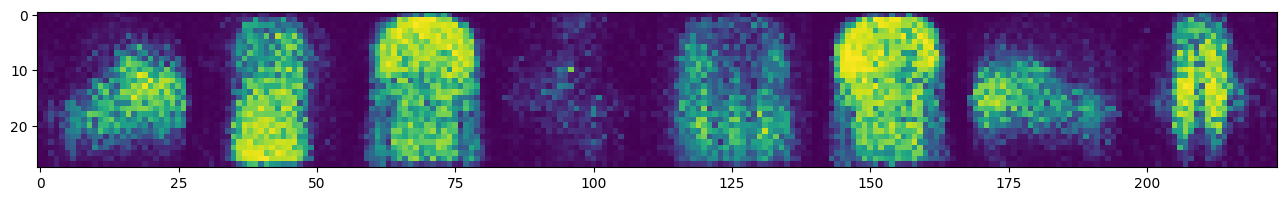

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 2/20] [D loss: 0.5645] [G loss: 0.9977]


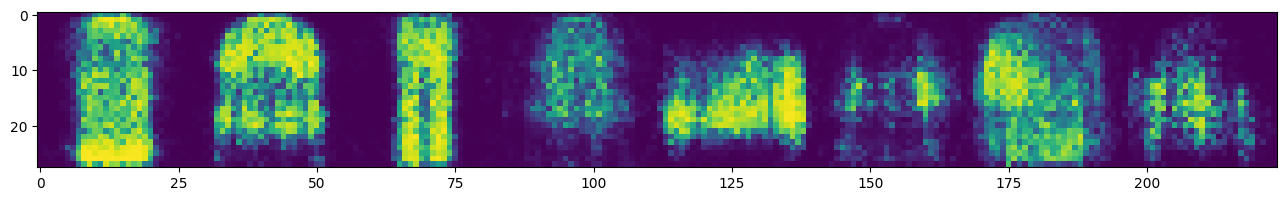

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 3/20] [D loss: 0.5845] [G loss: 0.9513]


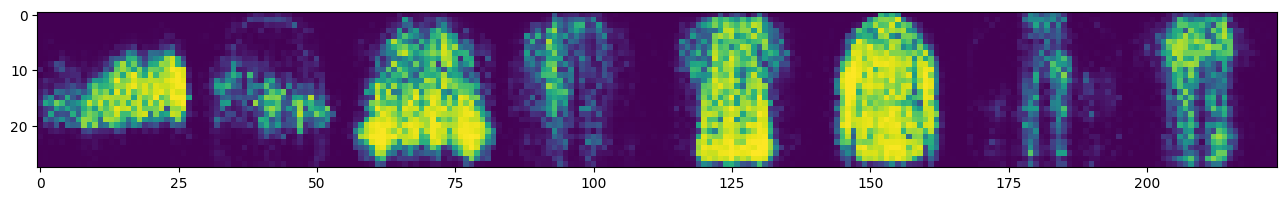

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 4/20] [D loss: 0.6064] [G loss: 0.9119]


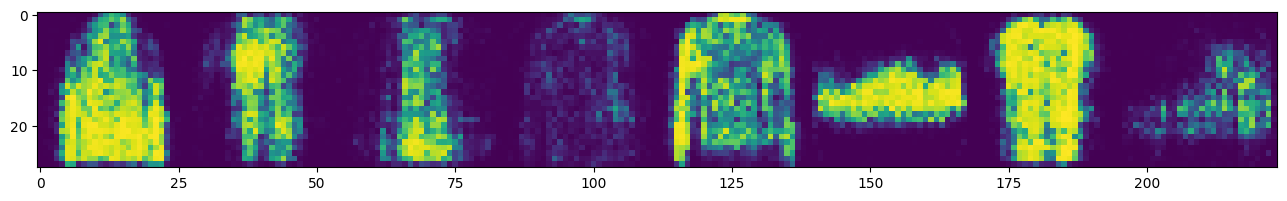

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 5/20] [D loss: 0.6209] [G loss: 0.8951]


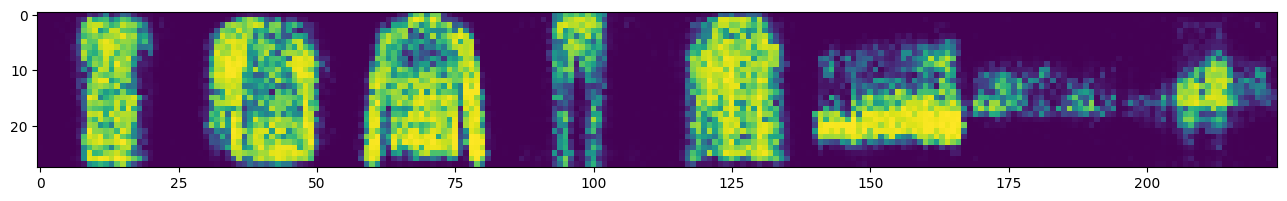

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 6/20] [D loss: 0.6350] [G loss: 0.8657]


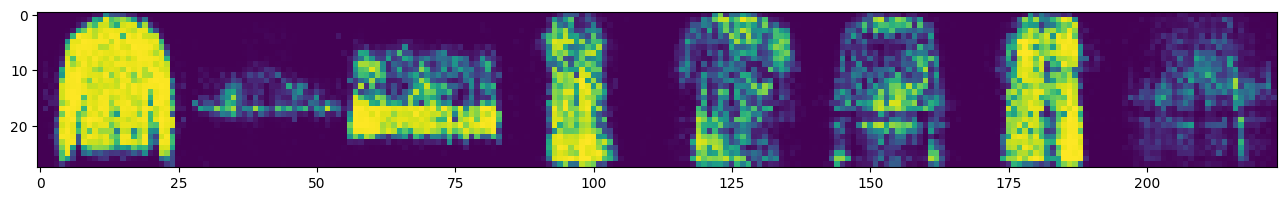

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 7/20] [D loss: 0.6402] [G loss: 0.8646]


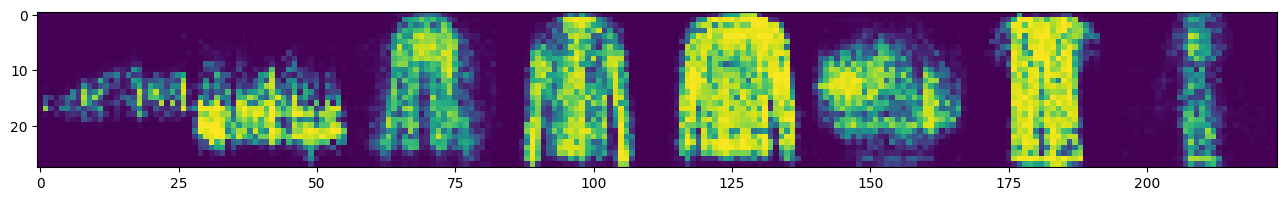

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 8/20] [D loss: 0.6473] [G loss: 0.8385]


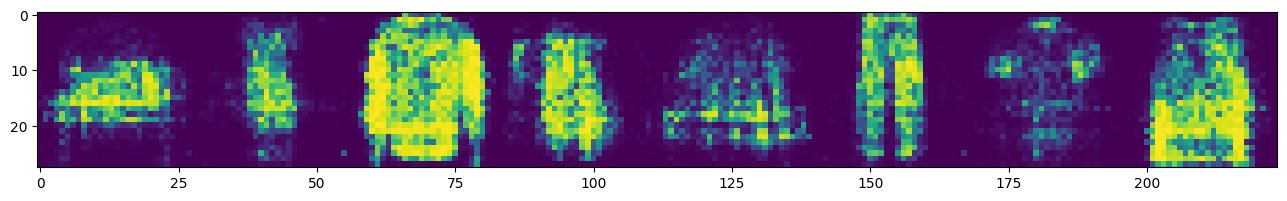

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 9/20] [D loss: 0.6534] [G loss: 0.8246]


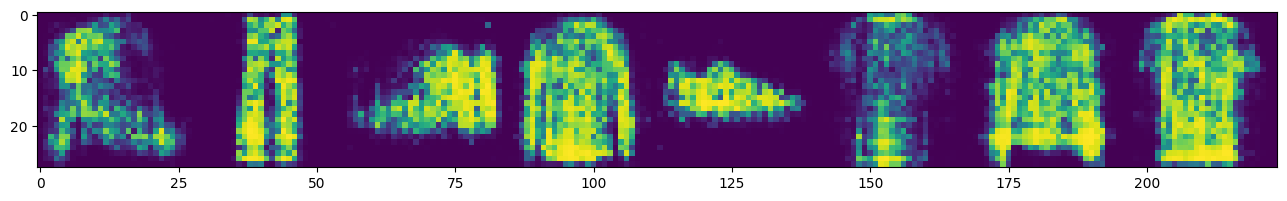

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 10/20] [D loss: 0.6572] [G loss: 0.8195]


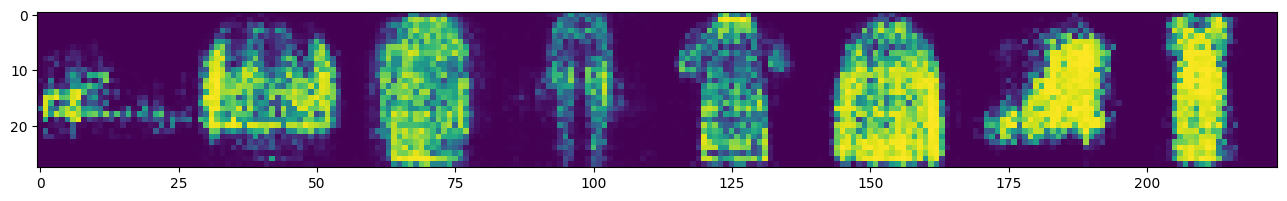

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 11/20] [D loss: 0.6579] [G loss: 0.8147]


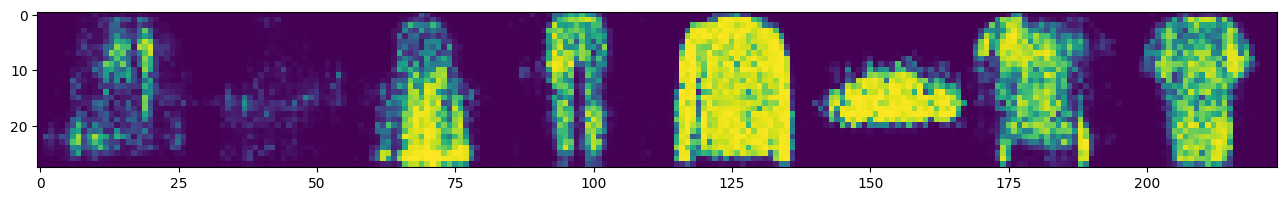

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 12/20] [D loss: 0.6594] [G loss: 0.8080]


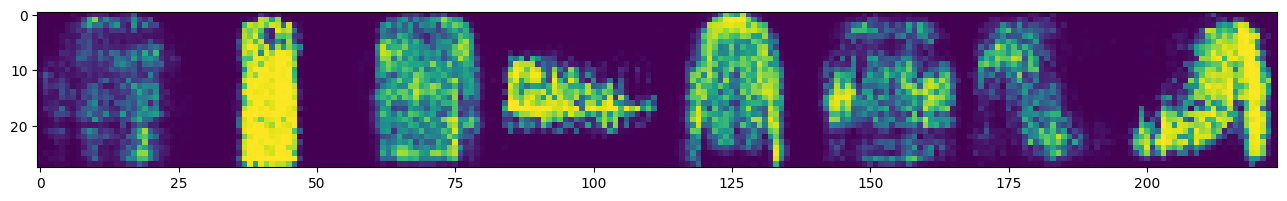

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 13/20] [D loss: 0.6616] [G loss: 0.7961]


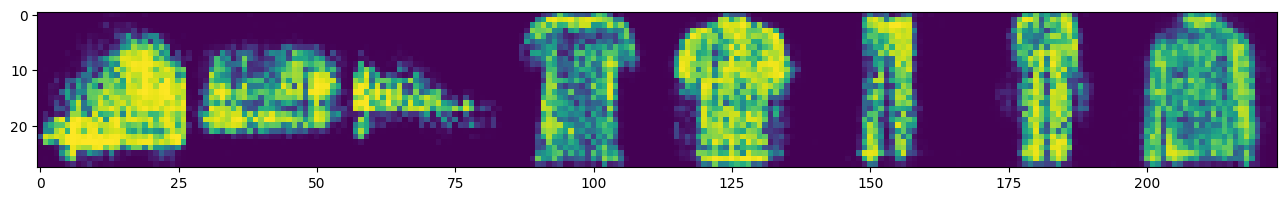

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 14/20] [D loss: 0.6638] [G loss: 0.7973]


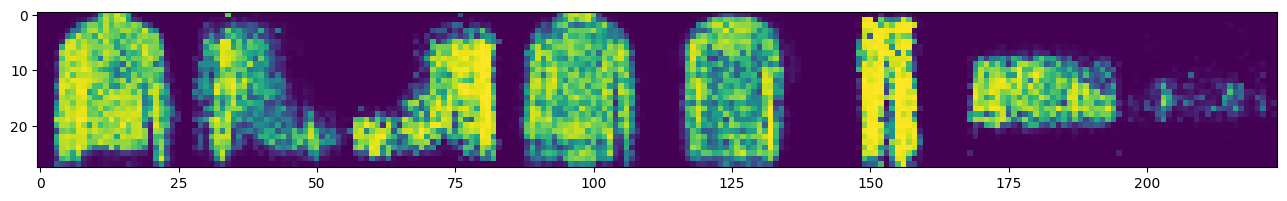

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 15/20] [D loss: 0.6623] [G loss: 0.7982]


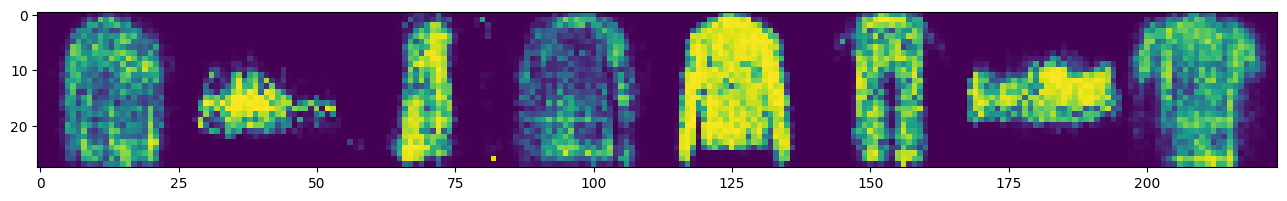

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 16/20] [D loss: 0.6638] [G loss: 0.7951]


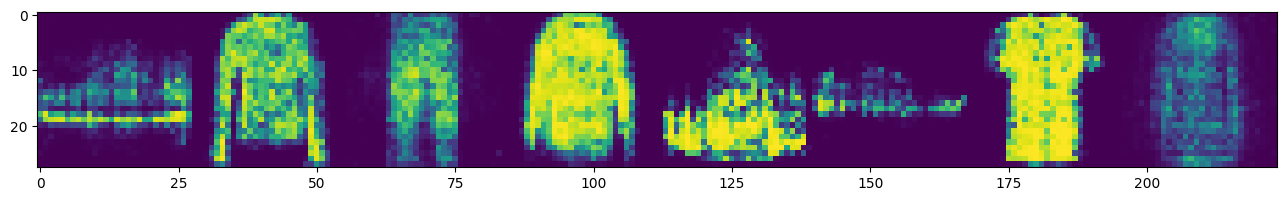

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 17/20] [D loss: 0.6657] [G loss: 0.7935]


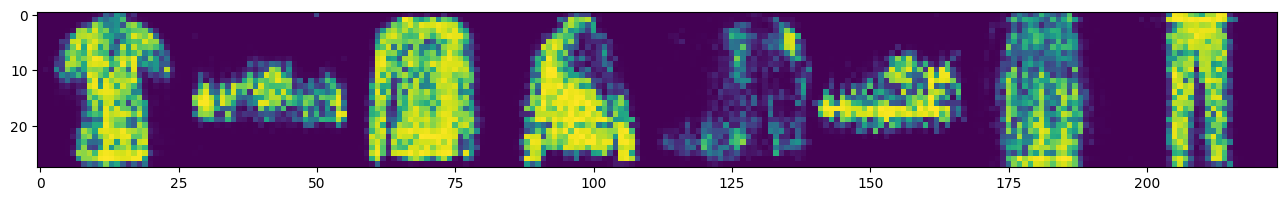

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 18/20] [D loss: 0.6682] [G loss: 0.7851]


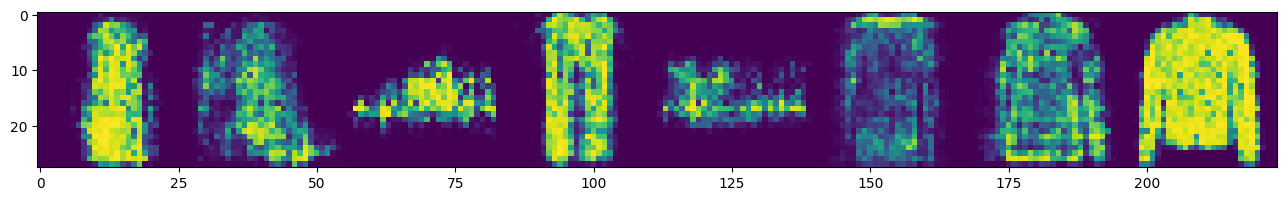

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 19/20] [D loss: 0.6684] [G loss: 0.7841]


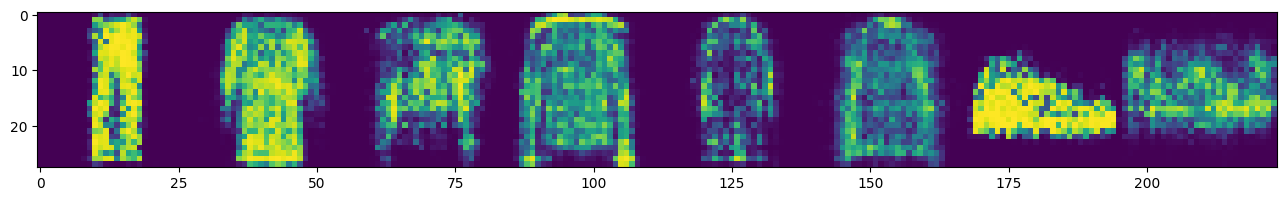

  0%|          | 0/468 [00:00<?, ?it/s]

[Epoch 20/20] [D loss: 0.6695] [G loss: 0.7799]


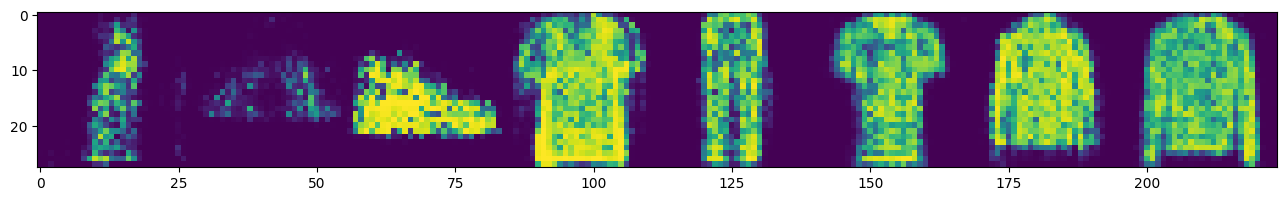

In [ ]:
gan = GANManager(latent_dim = 50) # You can pass your arguments to the call.
gan_history = gan.train(dataloader)

### ❓ **Question 3**
> - How can we generate images from a specific class in GAN?
To generate images from a specific class using a GAN, we use a Conditional GAN (cGAN), which takes both random noise and class labels as inputs. The generator learns to produce realistic images conditioned on these class labels, allowing us to explicitly generate images belonging to a chosen class.
- *(Bonus - 15 points)* Implement your idea and plot 8 images from each of the 10 classes.


## DDPM

Denoising diffusion probabilistic models (DDPMs) learn to generate images by gradually denoising a completely random pattern in a step-by-step process. The model learns a set of diffusion steps that describe how the noise evolves through time and a denoising function that removes the noise at each time step. The denoising function is typically implemented as a neural network that takes in the noisy data and the time step as input and outputs the denoised data. After iterative denoising steps over a time index, an image from the training distribution is generated. The overall procedure of training and sampling from DDPM is represented in the following pseudocodes from DDPM paper. For more details on the loss function and the sampling process, please refer to the course slides and the paper.

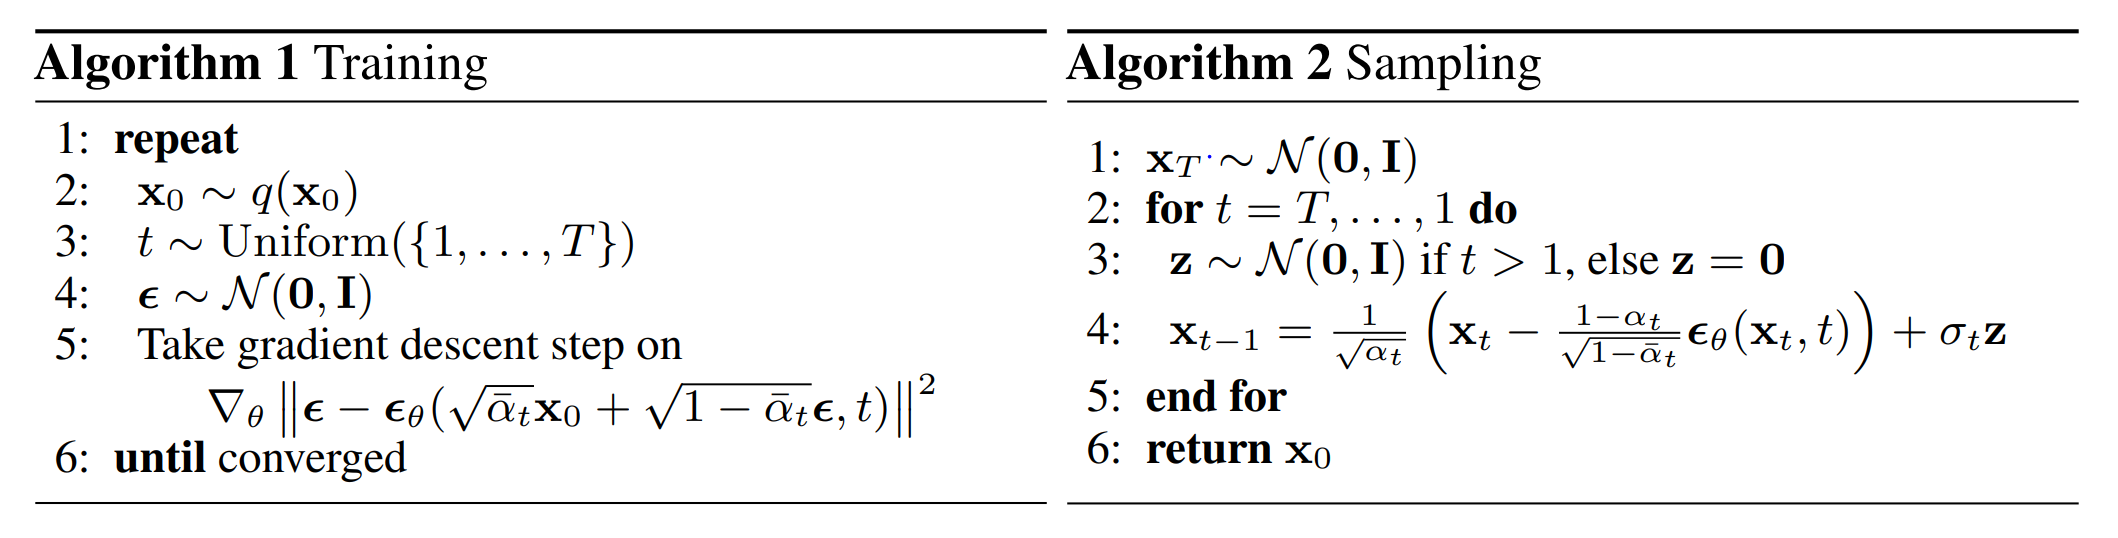

The pseudocode shows that the loss function is defined as an MSE on per time step noise and the predicted noise for the current time step. So we only need to train a model that learns to reverse the noise from an input image at a specific time step. In this notebook, we will use the architecture proposed by the paper, a UNet with image and time as the inputs and predicted noise as the output. They augment the regular UNet with several sub-modules and techniques such as ResNets, Attention modules, etc. We describe the expected architecture for this notebook:

+ *ResNet:* As a base sub-module, we define each ResNet block as two consecutive convolutional layers with a GELU activation in between and Group Normalization after each convolutional layer. You can use this module in Down/Up blocks. Also, by removing the residual connection, you can use this block as a convolutional network throughout the network.
+ *Attention:* This is also a sub-module consisting of a Layer Normalization, Multi-head Attention (use from `torch.nn`), a residual connection, a feed-forward network, and another residual connection.
+ *Conditional UNet:* Each Up/Down block in UNet accepts positionally-encoded time as an input. The time index is encoded and added to the output of the block. You can use the sinusoidal position embeddings proposed in [Attention is All You Need.](https://arxiv.org/pdf/1706.03762.pdf)

You can implement the following structure for UNet:

+ Convolutional block
+ Down block
+ Attention
+ Down block
+ Attention
+ Down block
+ Attention

+ Convolutional block (bottleneck)
+ Convolutional block (bottleneck)
+ Convolutional block (bottleneck)

+ Up block
+ Attention
+ Up block
+ Attention
+ Up block
+ Attention
+ Convolutional block

In [ ]:
##########################################################
# TODO (40 points):
# Complete each class based on the previous explanations.
##########################################################

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -(np.log(10000) / (half_dim - 1)))
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings
class ConvResNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.GELU()
        )
        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        return self.block(x) + self.residual(x)

class Attention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.qkv = nn.Linear(dim, dim * 3)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1).view(B, H*W, C)
        x = self.norm(x)
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        x = F.scaled_dot_product_attention(q, k, v)
        return x.view(B, H, W, C).permute(0, 3, 1, 2)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.conv = ConvResNet(in_ch, out_ch)
        self.down = nn.Conv2d(
            out_ch, out_ch,
            kernel_size=3,
            stride=2,
            padding=1
        )
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)

    def forward(self, x, t):
        x = self.conv(x)
        skip = x  # Save for skip connection
        x = self.down(x)
        t_emb = self.time_mlp(t)[..., None, None]
        return x + t_emb, skip
class Up(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, time_emb_dim=128):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvResNet(out_channels + skip_channels, out_channels)  # Fixed input channels
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)

    def forward(self, x, skip, t):
        x = self.up(x)

        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode='nearest')
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        t_emb = self.time_mlp(t).view(x.shape[0], -1, 1, 1)
        return x + t_emb

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        time_emb_dim = 128
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.GELU()
        )

        # Initial convolution
        self.init_conv = nn.Conv2d(C_IN, 64, kernel_size=3, padding=1)

        # Down blocks
        self.down1 = Down(64, 128, time_emb_dim)
        self.attn1 = Attention(128)
        self.down2 = Down(128, 256, time_emb_dim)
        self.attn2 = Attention(256)
        self.down3 = Down(256, 512, time_emb_dim)
        self.attn3 = Attention(512)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            ConvResNet(512, 512),
            ConvResNet(512, 512)
        )


        self.up1 = Up(512, 512, 256, time_emb_dim)
        self.up2 = Up(256, 256, 128, time_emb_dim)
        self.up3 = Up(128, 128, 64, time_emb_dim)

        self.final_conv = nn.Conv2d(64, C_IN, kernel_size=3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_embed(t)

        # Down path
        x1 = self.init_conv(x)
        x2, skip1 = self.down1(x1, t_emb)
        x2 = self.attn1(x2)
        x3, skip2 = self.down2(x2, t_emb)
        x3 = self.attn2(x3)
        x4, skip3 = self.down3(x3, t_emb)
        x4 = self.attn3(x4)

        # Bottleneck
        x = self.bottleneck(x4)

        # Up path with proper skip connections
        x = self.up1(x, skip3, t_emb)
        x = self.up2(x, skip2, t_emb)
        x = self.up3(x, skip1, t_emb)

        return self.final_conv(x)

In [ ]:
import math
from torch.amp import autocast, GradScaler
from torch.utils.checkpoint import checkpoint
ACCUM_STEPS = 2
class DDPMManager(nn.Module):
    def __init__(self, T=1000):
        super().__init__()
        self.T = T
        self.unet = UNet().to(DEVICE)
        self.optimizer = optim.AdamW(self.unet.parameters(), lr=LR)
        self.scaler = GradScaler()
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(
            self.optimizer, lr_lambda=lambda e: min((e+1)/1000, 1))


        # Cosine noise schedule
        self.betas = torch.linspace(1e-4, 0.02, T)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.register_buffer('sqrt_alpha_cumprod', torch.sqrt(self.alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alpha_cumprod', torch.sqrt(1 - self.alphas_cumprod))

    def train(self, dataloader):
        self.to(DEVICE)
        history = {'loss': []}
        accum_counter = 0

        for epoch in range(EPOCHS):
            self.unet.train()
            total_loss = 0
            pbar = tqdm(dataloader)

            for i, (images, _) in enumerate(pbar):
                images = images.to(DEVICE, non_blocking=True)

                with autocast(device_type='cuda' if 'cuda' in DEVICE else 'cpu'):

                    t = torch.randint(0, self.T, (images.size(0),), device=DEVICE)
                    noise = torch.randn_like(images)
                    noisy = (
                        self.sqrt_alpha_cumprod[t, None, None, None] * images +
                        self.sqrt_one_minus_alpha_cumprod[t, None, None, None] * noise
                    )
                    pred_noise = self.unet(noisy, t)
                    loss = F.mse_loss(pred_noise, noise) / ACCUM_STEPS


                self.scaler.scale(loss).backward()
                accum_counter += 1

                if accum_counter % ACCUM_STEPS == 0:
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                    self.optimizer.zero_grad()
                    self.scheduler.step()
                    accum_counter = 0

                total_loss += loss.item() * ACCUM_STEPS
                pbar.set_description(f"Loss: {total_loss/(i+1):.4f}")

            avg_loss = total_loss / len(dataloader)
            history['loss'].append(avg_loss)
            print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | LR: {self.scheduler.get_last_lr()[0]:.2e}")

            if (epoch+1) % 25 == 0:
                self.sample(8)

        return history

    @torch.inference_mode()
    def sample(self, n=8):
      self.unet.eval()
      x = torch.randn(n, C_IN, IMG_SIZE, IMG_SIZE, device=DEVICE)

      for t in reversed(range(self.T)):
          t_batch = torch.full((n,), t, device=DEVICE)
          pred_noise = self.unet(x, t_batch)
          alpha_t = self.alphas[t]
          alpha_cumprod_t = self.alphas_cumprod[t]

          x = (x - (1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t) * pred_noise)
          x /= torch.sqrt(alpha_t)

          if t > 0:
              x += torch.sqrt(self.betas[t]) * torch.randn_like(x)

      x = x.clamp(-1, 1) * 0.5 + 0.5  # Scale to [0,1]

      # Plot samples
      plt.figure(figsize=(16, 3))
      plt.imshow(torch.cat([x[i] for i in range(n)], dim=-1).permute(1, 2, 0).cpu())
      plt.axis('off')
      plt.show()

      return x  # Explicitly return generated samples



In [ ]:
ddpm = DDPMManager(T = 100).to(DEVICE) # You can pass your arguments to the call.
ddpm_history = ddpm.train(dataloader)

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.5316 | LR: 2.35e-05


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 2 | Loss: 0.2279 | LR: 4.69e-05


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 3 | Loss: 0.1750 | LR: 7.03e-05


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 4 | Loss: 0.1530 | LR: 9.37e-05


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 5 | Loss: 0.1419 | LR: 1.00e-04


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 6 | Loss: 0.1344 | LR: 1.00e-04


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 7 | Loss: 0.1298 | LR: 1.00e-04


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 8 | Loss: 0.1258 | LR: 1.00e-04


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 9 | Loss: 0.1240 | LR: 1.00e-04


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.1200 | LR: 1.00e-04


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 11 | Loss: 0.1183 | LR: 1.00e-04


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 12 | Loss: 0.1163 | LR: 1.00e-04


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 13 | Loss: 0.1158 | LR: 1.00e-04


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 14 | Loss: 0.1148 | LR: 1.00e-04


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 15 | Loss: 0.1132 | LR: 1.00e-04


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 16 | Loss: 0.1131 | LR: 1.00e-04


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 17 | Loss: 0.1119 | LR: 1.00e-04


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 18 | Loss: 0.1109 | LR: 1.00e-04


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 19 | Loss: 0.1102 | LR: 1.00e-04


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 20 | Loss: 0.1096 | LR: 1.00e-04


### ❓ **Question 4**
> +  How can we generate images from a specific target class in DDPM?
+  Implement your idea and plot one trajectory of denoised images per class.

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.0980


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 2 | Loss: 0.0542


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 3 | Loss: 0.0483


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 4 | Loss: 0.0464


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 5 | Loss: 0.0451


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 6 | Loss: 0.0433


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 7 | Loss: 0.0425


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 8 | Loss: 0.0425


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 9 | Loss: 0.0412


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.0402


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 11 | Loss: 0.0399


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 12 | Loss: 0.0401


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 13 | Loss: 0.0393


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 14 | Loss: 0.0389


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 15 | Loss: 0.0395


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 16 | Loss: 0.0380


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 17 | Loss: 0.0384


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 18 | Loss: 0.0382


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 19 | Loss: 0.0382


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 20 | Loss: 0.0382


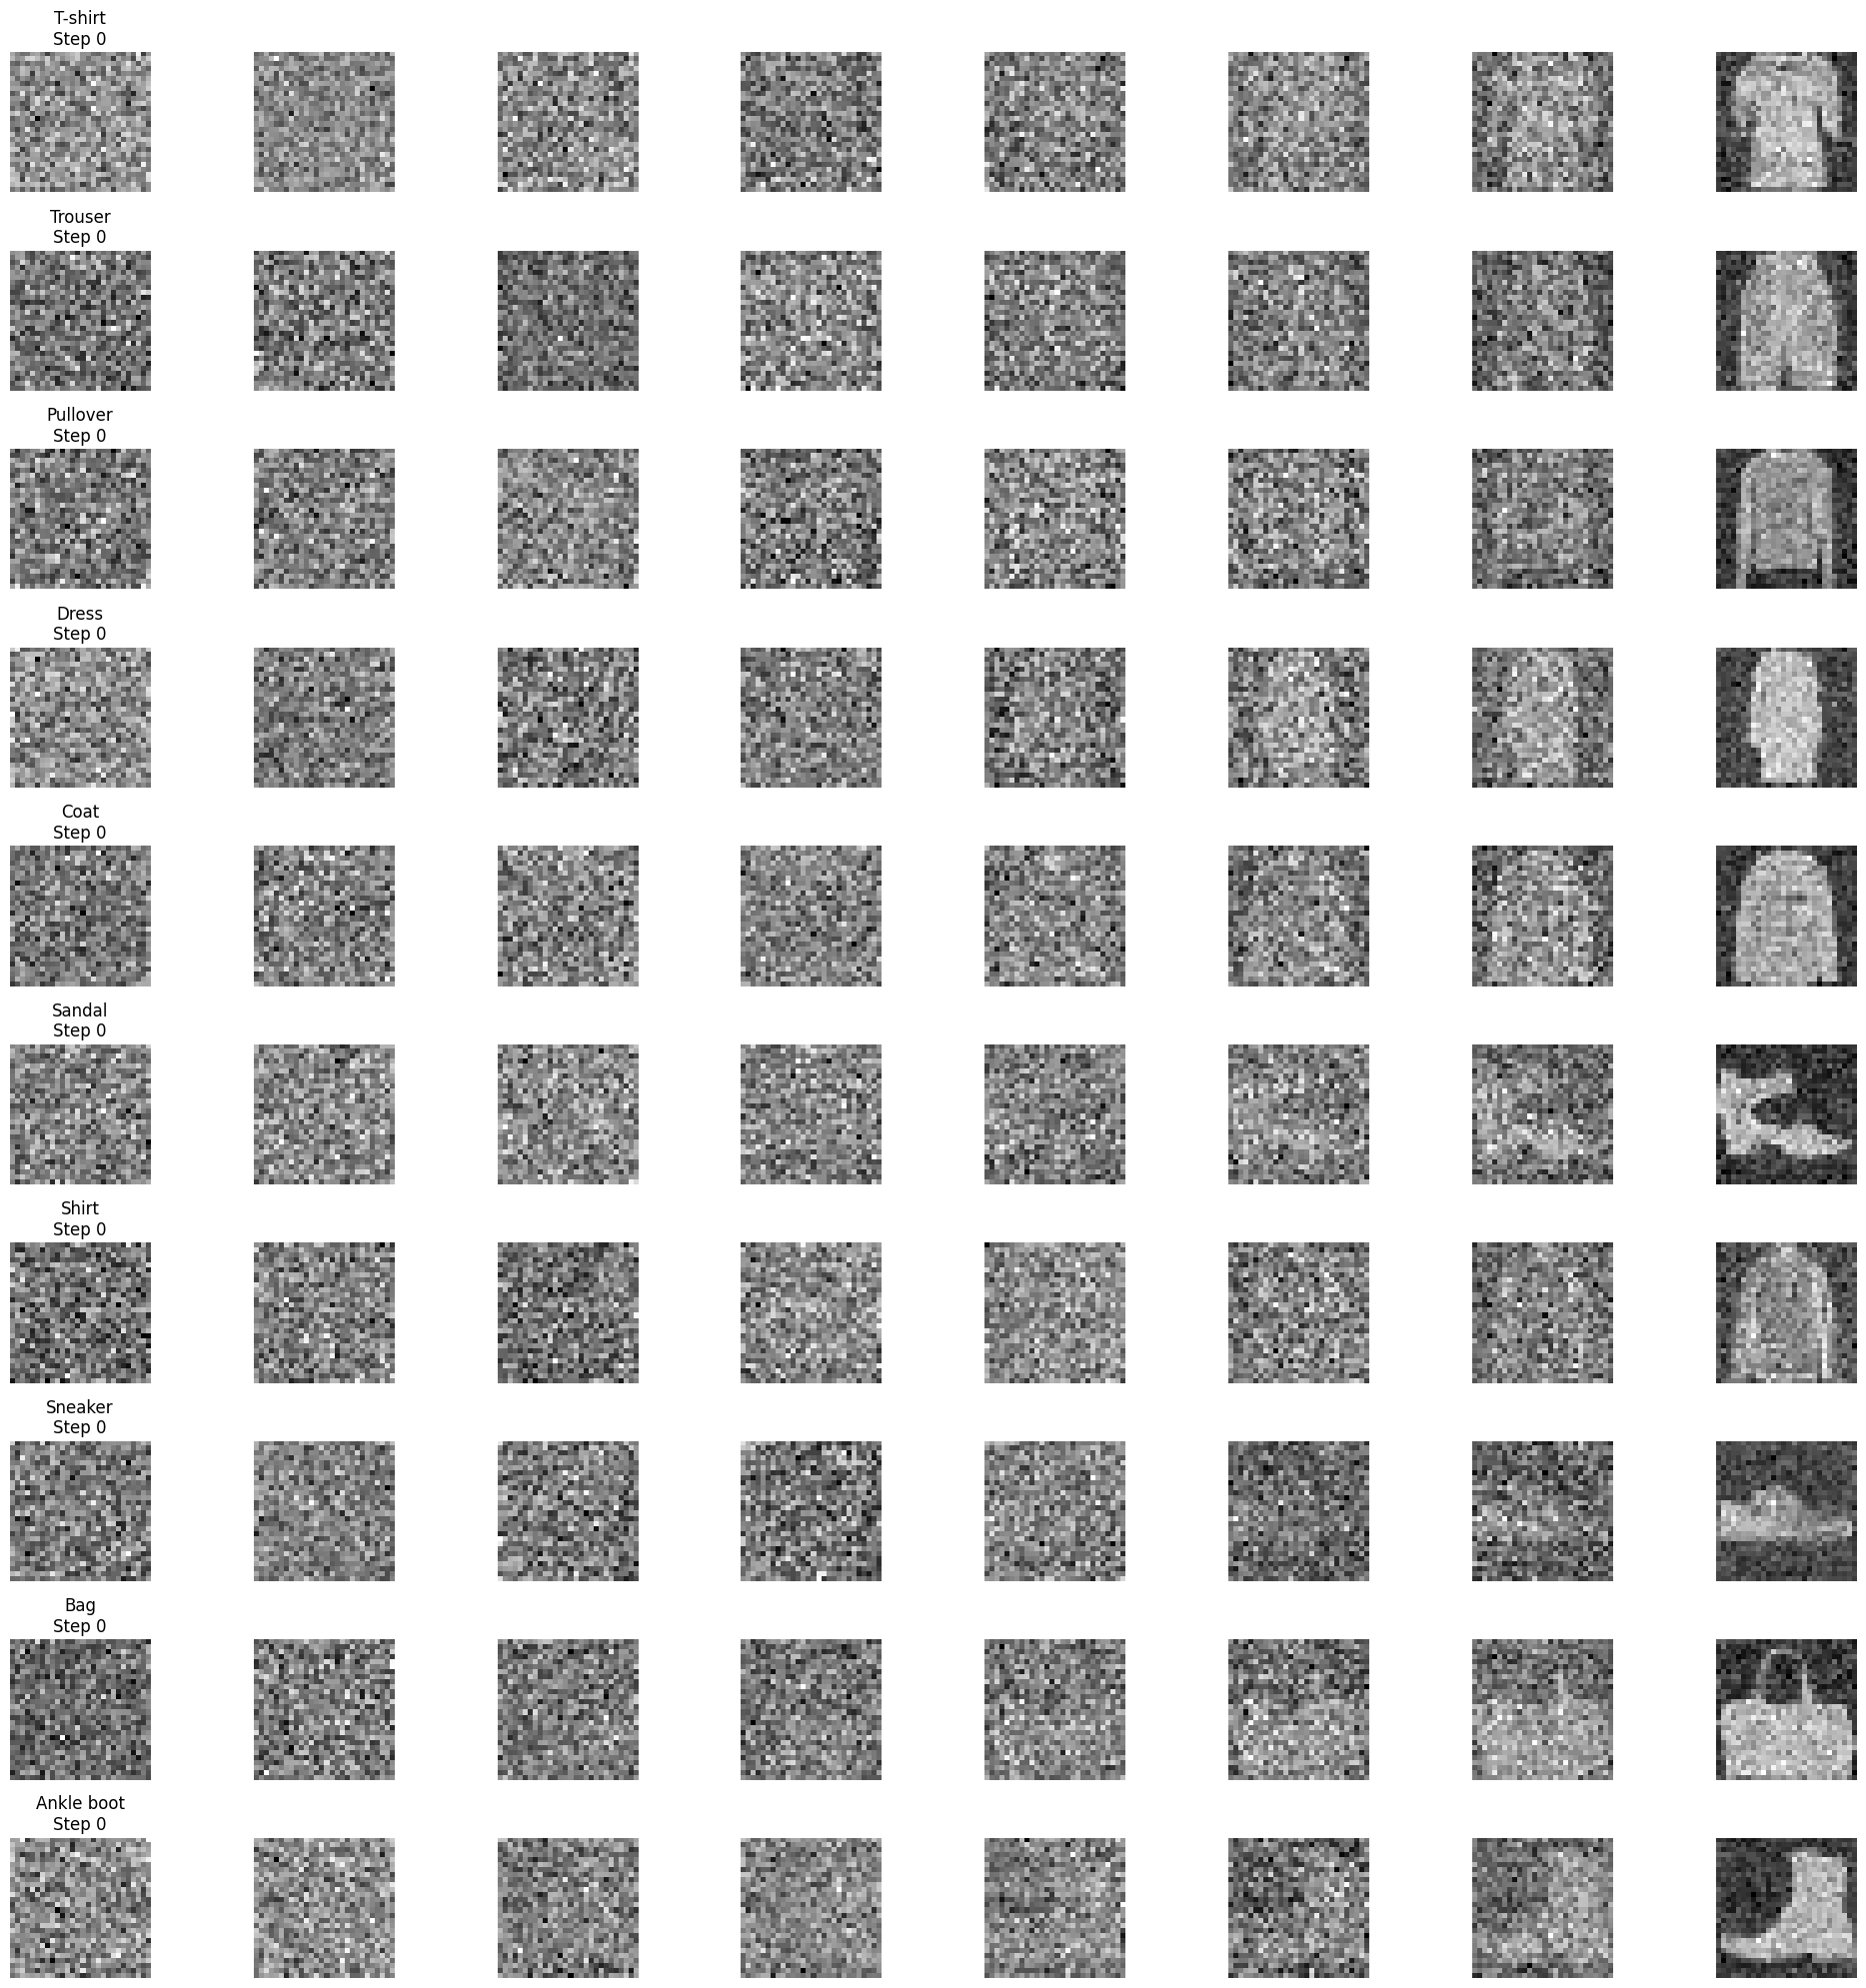

In [ ]:
NUM_CLASSES = 10
class ClassEmbedding(nn.Module):
    def __init__(self, num_classes, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_classes, embedding_dim)

    def forward(self, class_labels):
        return self.embedding(class_labels)

class ConvResNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.GELU()
        )
        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        return self.block(x) + self.residual(x)

class Attention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.qkv = nn.Linear(dim, dim * 3)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1).view(B, H*W, C)
        x = self.norm(x)
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        x = F.scaled_dot_product_attention(q, k, v)
        return x.view(B, H, W, C).permute(0, 3, 1, 2)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim):
        super().__init__()
        self.conv = ConvResNet(in_ch, out_ch)
        self.down = nn.Conv2d(out_ch, out_ch, 3, stride=2, padding=1)
        self.emb_proj = nn.Linear(emb_dim, out_ch)

    def forward(self, x, emb):
        x = self.conv(x)
        skip = x
        x = self.down(x)
        emb = self.emb_proj(emb)[..., None, None]
        return x + emb, skip

class Up(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, emb_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(
            in_ch, out_ch,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1
        )
        self.conv = ConvResNet(out_ch + skip_ch, out_ch)
        self.emb_proj = nn.Linear(emb_dim, out_ch)  # Projects to out_ch

    def forward(self, x, skip, emb):

        x = self.up(x)


        emb = self.emb_proj(emb)[..., None, None]
        x = x + emb


        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode='nearest')


        x = torch.cat([x, skip], dim=1)


        return self.conv(x)

class ClassConditionalUNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.time_dim = 128
        self.class_dim = 128
        self.emb_dim = self.time_dim + self.class_dim

        # Embedding layers
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbeddings(self.time_dim),
            nn.Linear(self.time_dim, self.time_dim),
            nn.GELU()
        )
        self.class_embed = nn.Embedding(num_classes, self.class_dim)

        # Architecture components
        self.init_conv = nn.Conv2d(C_IN, 64, 3, padding=1)

        # Down blocks
        self.down1 = Down(64, 128, self.emb_dim)
        self.attn1 = Attention(128)
        self.down2 = Down(128, 256, self.emb_dim)
        self.attn2 = Attention(256)
        self.down3 = Down(256, 512, self.emb_dim)
        self.attn3 = Attention(512)  # Added attention layer

        # Bottleneck
        self.bottleneck = nn.Sequential(
            ConvResNet(512, 512),
            ConvResNet(512, 512)
        )

        # Up blocks
        self.up1 = Up(512, 512, 256, self.emb_dim)
        self.up2 = Up(256, 256, 128, self.emb_dim)
        self.up3 = Up(128, 128, 64, self.emb_dim)

        self.final_conv = nn.Conv2d(64, C_IN, 3, padding=1)

    def forward(self, x, t, class_labels):
        t_emb = self.time_embed(t)
        c_emb = self.class_embed(class_labels)
        emb = torch.cat([t_emb, c_emb], dim=-1)


        x1 = self.init_conv(x)
        x2, skip1 = self.down1(x1, emb)
        x2 = self.attn1(x2)

        x3, skip2 = self.down2(x2, emb)
        x3 = self.attn2(x3)

        x4, skip3 = self.down3(x3, emb)
        x4 = self.attn3(x4)  # Apply attention after skip connection

        # Bottleneck
        x = self.bottleneck(x4)

        # Up path with corrected skip references
        x = self.up1(x, skip3, emb)
        x = self.up2(x, skip2, emb)
        x = self.up3(x, skip1, emb)

        return self.final_conv(x)

# DDPM Manager
class ClassConditionalDDPMManager(nn.Module):
    def __init__(self, T=1000):
        super().__init__()
        self.T = T
        self.unet = ClassConditionalUNet().to(DEVICE)
        self.optimizer = optim.AdamW(self.unet.parameters(), lr=LR)
        self.scaler = GradScaler()

        # Noise schedule
        self.betas = torch.linspace(1e-4, 0.02, T)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.register_buffer('sqrt_alpha_cumprod', torch.sqrt(self.alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alpha_cumprod', torch.sqrt(1 - self.alphas_cumprod))

    def train(self):
        history = {'loss': []}
        for epoch in range(EPOCHS):
            self.unet.train()
            total_loss = 0
            pbar = tqdm(dataloader)

            for i, (images, labels) in enumerate(pbar):
                images = images.to(DEVICE, non_blocking=True)
                labels = labels.to(DEVICE)

                with autocast(device_type='cuda' if 'cuda' in DEVICE else 'cpu'):
                    t = torch.randint(0, self.T, (images.size(0),), device=DEVICE)
                    noise = torch.randn_like(images)
                    noisy = (
                        self.sqrt_alpha_cumprod[t, None, None, None] * images +
                        self.sqrt_one_minus_alpha_cumprod[t, None, None, None] * noise
                    )
                    pred_noise = self.unet(noisy, t, labels)
                    loss = F.mse_loss(pred_noise, noise)

                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()

                total_loss += loss.item()
                pbar.set_description(f"Loss: {total_loss/(i+1):.4f}")

            avg_loss = total_loss / len(dataloader)
            print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")
            history['loss'].append(avg_loss)

            if (epoch+1) % 25 == 0:
                self.plot_class_trajectories()

        return history

    @torch.inference_mode()
    def sample(self, num_samples, class_label, save_steps=50):
        self.unet.eval()
        class_labels = torch.full((num_samples,), class_label,
                                device=DEVICE, dtype=torch.long)

        x = torch.randn(num_samples, C_IN, IMG_SIZE, IMG_SIZE, device=DEVICE)
        trajectory = []

        for i, t in enumerate(reversed(range(self.T))):
            t_batch = torch.full((num_samples,), t, device=DEVICE)
            pred_noise = self.unet(x, t_batch, class_labels)

            alpha_t = self.alphas[t]
            alpha_cumprod_t = self.alphas_cumprod[t]

            x = (x - (1 - alpha_t)/torch.sqrt(1 - alpha_cumprod_t) * pred_noise)
            x /= torch.sqrt(alpha_t)

            if t > 0:
                x += torch.sqrt(self.betas[t]) * torch.randn_like(x)

            if i % save_steps == 0:
                trajectory.append(x.detach().cpu())

        return trajectory

    def plot_class_trajectories(self):
        class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                      'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

        plt.figure(figsize=(20, 20))
        for class_idx in range(NUM_CLASSES):
            trajectory = self.sample(1, class_idx, save_steps=100)
            steps = np.linspace(0, len(trajectory)-1, 8, dtype=int)

            for i, step in enumerate(steps):
                img = trajectory[step][0].squeeze().numpy()
                plt.subplot(NUM_CLASSES, 8, class_idx*8 + i + 1)
                plt.imshow(img, cmap='gray')
                plt.title(f"{class_names[class_idx]}\nStep {step*100}" if i==0 else "")
                plt.axis('off')

        plt.tight_layout()
        plt.show()

# Initialize and train
cddpm = ClassConditionalDDPMManager().to(DEVICE)
history = cddpm.train()
cddpm.plot_class_trajectories()

## Comparisons

History of each training has been stored in `[MODEL]_history`. Plot the losses for each model. Also sample images from each model and compare your results.

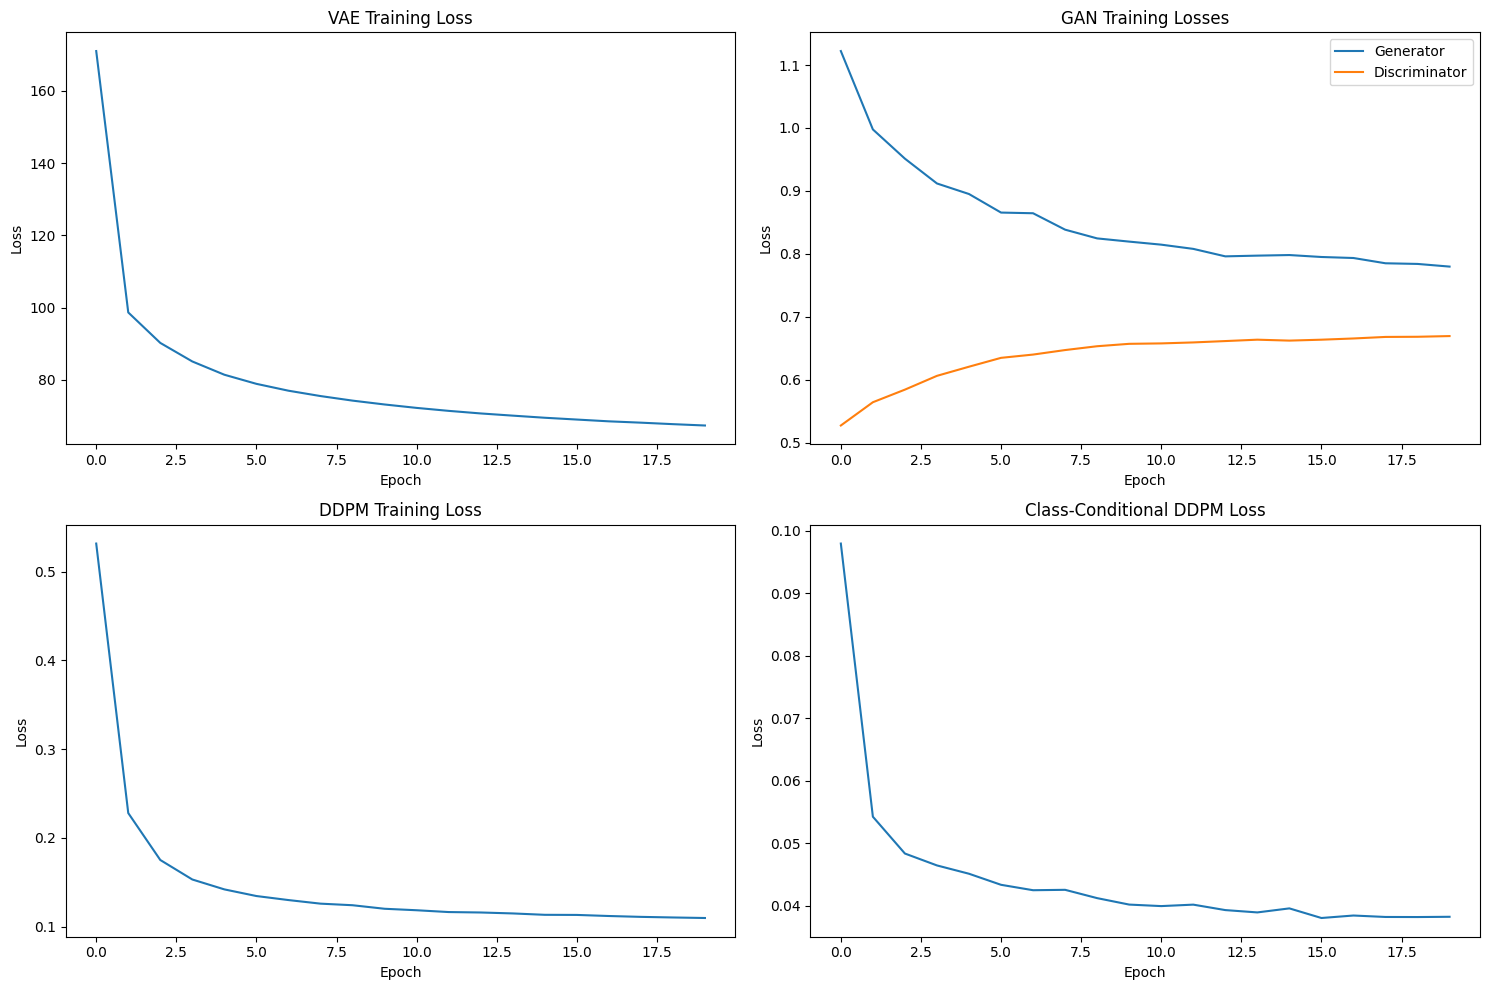

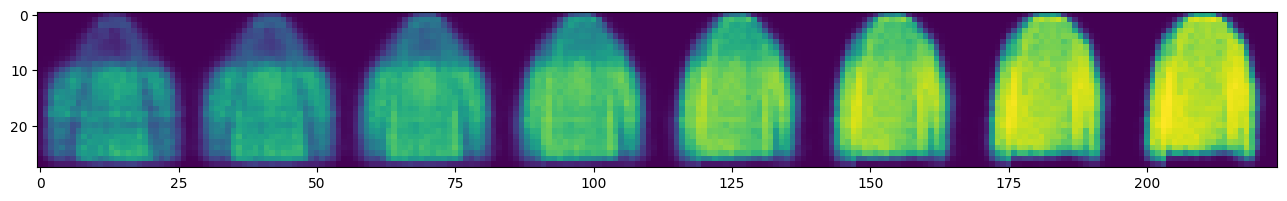

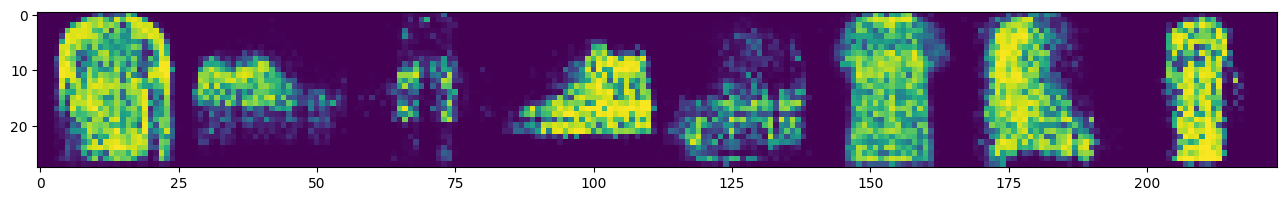

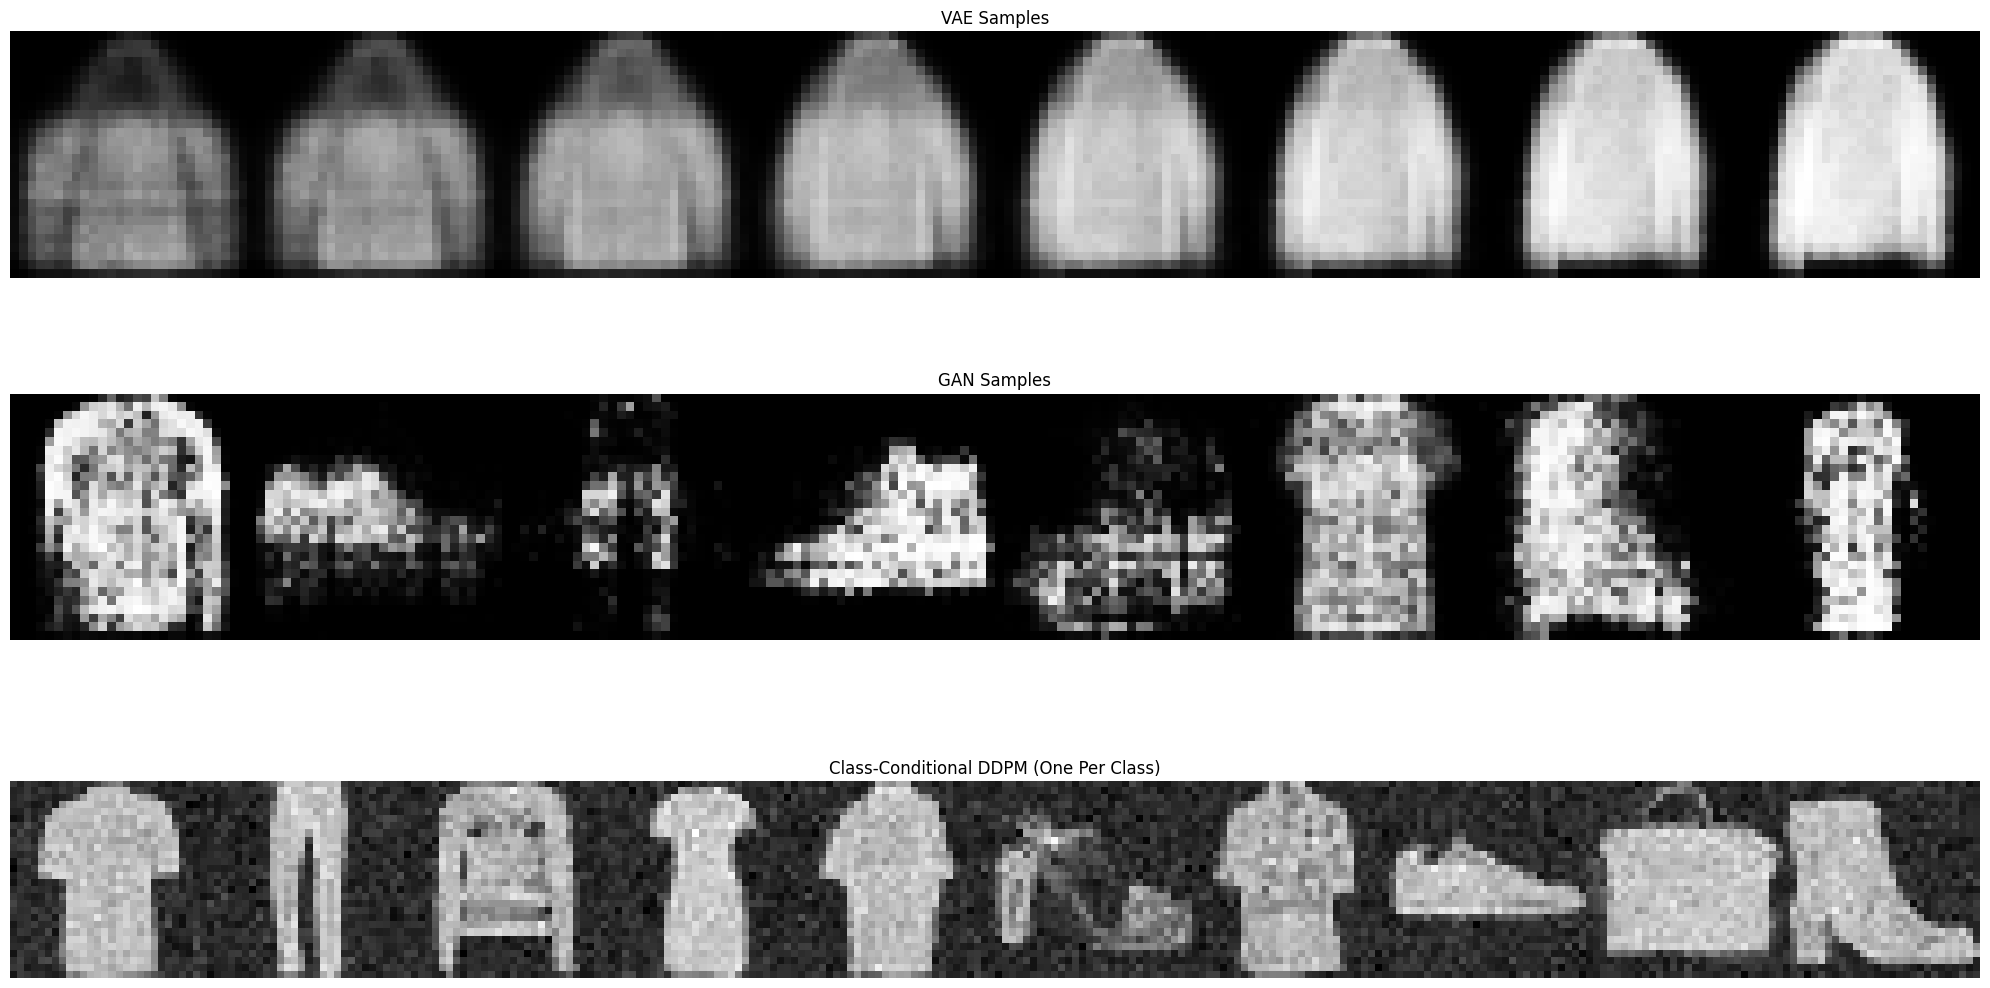

In [ ]:
def plot_losses():
    plt.figure(figsize=(15, 10))

    # VAE Loss
    plt.subplot(2, 2, 1)
    plt.plot(vae_history['loss'])
    plt.title('VAE Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # GAN Losses
    plt.subplot(2, 2, 2)
    plt.plot(gan_history['g_loss'], label='Generator')
    plt.plot(gan_history['d_loss'], label='Discriminator')
    plt.title('GAN Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # DDPM Loss
    plt.subplot(2, 2, 3)
    plt.plot(ddpm_history['loss'])
    plt.title('DDPM Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Class-Conditional DDPM Loss
    plt.subplot(2, 2, 4)
    plt.plot(history['loss'])
    plt.title('Class-Conditional DDPM Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()


def compare_samples( n=8):
    vae_samples = vae.sample(n)
    gan_samples = gan.sample(n)




    class_samples = []
    for class_idx in range(10):
        trajectory = cddpm.sample(1, class_label=class_idx)
        final_sample = trajectory[-1].squeeze().cpu().unsqueeze(0)
        class_samples.append(final_sample)

    vae_list = [vae_samples[i] for i in range(n)]
    gan_list = [gan_samples[i] for i in range(n)]


    vae_grid = torch.cat(vae_list, dim=-1)
    gan_grid = torch.cat(gan_list, dim=-1)

    class_grid = torch.cat(class_samples, dim=-1)

    plt.figure(figsize=(20, 15))

    plt.subplot(4, 1, 1)
    plt.imshow(vae_grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.title('VAE Samples')
    plt.axis('off')

    plt.subplot(4, 1, 2)
    plt.imshow(gan_grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.title('GAN Samples')
    plt.axis('off')


    plt.subplot(4, 1, 3)
    plt.imshow(class_grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.title('Class-Conditional DDPM (One Per Class)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Execute comparisons
plot_losses()
compare_samples()